<a href="https://colab.research.google.com/github/krember/sarcasm_detection/blob/master/Sarcasm_Detection_Local_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Sarcasm Detection Problem

We have decided to work on Sarcase Detection project as that was really interesting for us and also it was worthy to figure out how the NN will be able to distinguish the sarcasm from the text while even some human being are not able to.
Also in our everyday life we usually see big and attractive news headlines (sometimes fiables,sometimes not at all).
Could you really know which one is real and which one is fake ?(My granny and sometimes even mom cannot! :D )

We found the dataset from Kaggle and it is the collection of news headlines from TheOnion and HuffPost.
Both of these newspapers are collecting the information about current events.
TheOnion headlines both in brief and in photos categories are all sarcasric context while at the same time the HuffPost has only non sarcastic headlines.

In our dataset we have both of them (sarcastic and non-sarcastic).
The advantages of these data sets are

1. Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.
2. Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.
3. Unlike tweets which are replies to other tweets, the news headlines we obtained are self-contained. This would help us in teasing apart the real sarcastic elements.
4. Dataset is nor noisy neither imbalanced (based on what google ml developers claim https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data )

As you could already see our benchmark is the tweeter sarcasm detection analysis and other social media sarcasm detections based on imbalanced classificaion (in our case the data used was not balanced neither).

Here is the article we used to look up on https://www.researchgate.net/publication/278658179_Sarcasm_Detection_in_Social_Media_Based_on_Imbalanced_Classification.




Before starting the coding part of the work one should always have the imported the libraries needed.

In [0]:
import numpy as np
import pandas as pd
import torch.optim as optim
import time
import spacy
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torchtext import data
from torchtext import datasets
from torch import nn, optim

The dataset is imported from the github and it is stored in JSON format.
You can also see that below there are the links to the articles,their headlines and also the information about being sarcastic (0-not sarcastic,1 sarcasric)


In [9]:
#Let's start from providing Colab access to Google Drive to be able load the file with the data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
data_GH_path = 'https://raw.githubusercontent.com/krember/sarcasm_detection/master/Sarcasm_Headlines_Dataset.json'

df = pd.read_json(data_GH_path, lines = True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [11]:
df = df[['headline','is_sarcastic']]
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


Text(0.5, 1.0, 'Sarcasm vs Non-sarcasm')

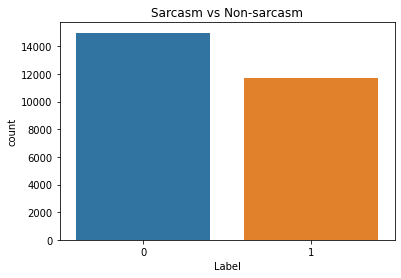

In [12]:
# Check for normalization
sns.countplot(df.is_sarcastic)
plt.xlabel('Label')
plt.title('Sarcasm vs Non-sarcasm')

In [0]:
# Transform dataset to have only headline and sarcastic label
# Also split headline text into words
HEADLINE = data.Field(tokenize='spacy', include_lengths = True)
ISSARCASTIC = data.LabelField()

sarcasm_data = data.TabularDataset(
    path = '/content/drive/My Drive/Deep Learning - AUA/Sarcasm Detection/Sarcasm_Headlines_Dataset.json',
    format='json',
    fields={
        'headline':('headline', HEADLINE),
        'is_sarcastic':('sarcastic', ISSARCASTIC)
    }
)

In [14]:
print(vars(sarcasm_data[0]))

{'headline': ['former', 'versace', 'store', 'clerk', 'sues', 'over', 'secret', "'", 'black', 'code', "'", 'for', 'minority', 'shoppers'], 'sarcastic': 0}


In [15]:
# Not a good idea to analyse words individually
# However, it is obvious that Trump is the largest source of sarcastic headlines )))
from collections import Counter
c = Counter(" ".join(df["headline"]).split()).most_common(20)
c
# Thinking of TF-IDF for future

[('to', 8206),
 ('of', 5593),
 ('the', 5177),
 ('in', 4170),
 ('for', 3297),
 ('a', 2961),
 ('on', 2371),
 ('and', 1885),
 ('with', 1797),
 ('is', 1666),
 ('new', 1485),
 ('man', 1229),
 ('from', 1221),
 ('at', 1189),
 ('trump', 1157),
 ('about', 1051),
 ('you', 914),
 ('by', 885),
 ('this', 882),
 ('after', 838)]

In [0]:
# Split to train and test
train_data, test_data = sarcasm_data.split()

In [17]:
len(test_data)

8013

In [18]:
# Bulding vocabulary from each sequence of training data
HEADLINE.build_vocab(train_data, 
                 max_size = 50_000, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

ISSARCASTIC.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:29, 2.21MB/s]                           
100%|█████████▉| 399114/400000 [00:24<00:00, 16721.38it/s]

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, test_data), 
    batch_size = 64,
    sort_key = lambda x:len(x.headline),
    sort_within_batch = True,
    device = device)

In [0]:
# recurrent neural network (RNN)
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional,
                          dropout=dropout)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        return self.fc(hidden)

In [0]:
# Define RNN model ( hyperparameters )
EMBEDDING_DIM = 100
PAD_IDX = HEADLINE.vocab.stoi[HEADLINE.pad_token]

model = RNN(vocab_size = len(HEADLINE.vocab), embedding_dim = EMBEDDING_DIM, hidden_dim = 256,
            output_dim = 1, n_layers = 2, bidirectional = True, dropout = 0.5, pad_idx = PAD_IDX)

In [22]:
# Print model parameters summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,504,657 trainable parameters


In [23]:
# Dense vector representation for words
pretrained_embeddings = HEADLINE.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = HEADLINE.vocab.stoi[HEADLINE.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.8970e-01,  5.0024e-02,  1.9084e-01,  ..., -3.9804e-01,
          4.7647e-01, -1.5983e-01],
        ...,
        [ 3.4814e-01,  2.5838e-01, -8.8865e-01,  ...,  2.7634e-02,
         -9.2952e-01,  8.2323e-02],
        [ 1.1097e-01,  3.6155e-01,  2.0370e-01,  ...,  2.2696e-01,
          3.0238e-01, -5.6025e-04],
        [ 7.6493e-01,  1.3564e-02,  4.6148e-01,  ...,  1.6122e-01,
          5.5549e-01, -3.4158e-01]])


In [24]:
# Learning rate optimization
optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

100%|█████████▉| 399114/400000 [00:40<00:00, 16721.38it/s]

In [0]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    return correct.sum() / len(correct)

In [0]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0.0
    epoch_acc = 0.0
    for batch in iterator:
        optimizer.zero_grad()
        text, text_lengths = batch.headline
        
        predictions = model(text, text_lengths).squeeze(1)
#         print(predictions)
        loss = criterion(predictions, batch.sarcastic.type_as(predictions))
        acc = binary_accuracy(predictions, batch.sarcastic.type_as(predictions))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [27]:
# Training the model
N_EPOCHS = 15

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # Calculated training time of this epoch
    end_time = time.time()
    elapsed_time = end_time - start_time
    epoch_mins = int(elapsed_time / 60)
    epoch_secs = int(elapsed_time - (epoch_mins * 60))
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 0.500 | Train Acc: 75.38%
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.360 | Train Acc: 84.10%
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.297 | Train Acc: 87.58%
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.245 | Train Acc: 89.80%
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.208 | Train Acc: 91.77%
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.174 | Train Acc: 93.22%
Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 0.146 | Train Acc: 94.35%
Epoch: 08 | Epoch Time: 0m 5s
	Train Loss: 0.126 | Train Acc: 95.02%
Epoch: 09 | Epoch Time: 0m 5s
	Train Loss: 0.106 | Train Acc: 95.99%
Epoch: 10 | Epoch Time: 0m 5s
	Train Loss: 0.099 | Train Acc: 96.22%
Epoch: 11 | Epoch Time: 0m 5s
	Train Loss: 0.081 | Train Acc: 96.90%
Epoch: 12 | Epoch Time: 0m 5s
	Train Loss: 0.069 | Train Acc: 97.51%
Epoch: 13 | Epoch Time: 0m 5s
	Train Loss: 0.063 | Train Acc: 97.61%
Epoch: 14 | Epoch Time: 0m 5s
	Train Loss: 0.053 | Train Acc: 98.02%
Epoch: 15 | Epoch Time: 0m 5s
	Tra

In [0]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.headline
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.sarcastic.type_as(predictions))
            
            acc = binary_accuracy(predictions, batch.sarcastic.type_as(predictions))

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [29]:
# model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.358 | Test Acc: 89.78%


In [0]:
# Give sarcasm probability of the given sentence based on our model
def predict_sarcasm(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in spacy.load('en').tokenizer(sentence)]
    indexed = [HEADLINE.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()

In [31]:
predict_sarcasm(model, "Cats loving dogs")

0.022778959944844246